<a href="https://colab.research.google.com/github/gonzacastro/SOA-TP3-HPC/blob/main/EJ1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1 Introduccion

En este cuaderno se desarrollará un filtro fotografico que permitira invertir los colores de cualquier imagen.

 2 Armado de ambiente 

In [1]:
imgURL = "https://github.com/gonzacastro/SOA-TP3-HPC/blob/main/ZAWARUDO.png?raw=true"#@param {type:"string"}
!wget {imgURL} -O imagen.png
!pip install pycuda


--2021-07-05 00:22:09--  https://github.com/gonzacastro/SOA-TP3-HPC/blob/main/ZAWARUDO.png?raw=true
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/gonzacastro/SOA-TP3-HPC/raw/main/ZAWARUDO.png [following]
--2021-07-05 00:22:09--  https://github.com/gonzacastro/SOA-TP3-HPC/raw/main/ZAWARUDO.png
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gonzacastro/SOA-TP3-HPC/main/ZAWARUDO.png [following]
--2021-07-05 00:22:09--  https://raw.githubusercontent.com/gonzacastro/SOA-TP3-HPC/main/ZAWARUDO.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting resp

3 Desarollo

Imagen del filtro: imagen.png -RGB- [1080, 1920]
Thread: [ 16 , 16  ], Bloque : [ 68 , 120 ]
Total de Thread: [ 1088 , 1920  ]  =  2088960
Tiempo TOTAL:  1497.164 [ms]
Tiempo GPU  :  1.639 [ms]


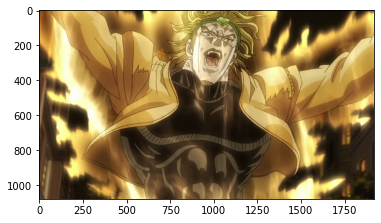

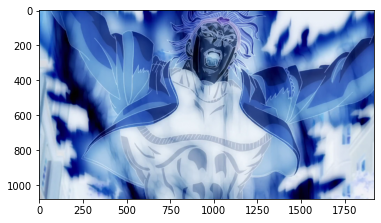

In [2]:
try:
  %matplotlib inline
  from datetime import datetime
  tiempo_total = datetime.now()

  import matplotlib.pyplot as plt
  import sys
  import numpy
  from PIL import Image 
  import pycuda.driver as cuda
  import pycuda.autoinit
  from pycuda.compiler import SourceModule

  tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0

  img_nombre = 'imagen.png'

  image = Image.open( img_nombre ) 

    
  # summarize some details about the image 
  img_alto, img_ancho = image.size 

  # Convierto la imagen comprimida en JPEG/PNG a array
  img_O_cpu = numpy.asarray(image)
  img_R_cpu = numpy.empty_like( img_O_cpu)

  # Reservo los 2 vectores en GPU(3 pixeles usa RGB * (el tamaño del array))
  img_O_gpu = cuda.mem_alloc( img_O_cpu.nbytes )
  img_R_gpu = cuda.mem_alloc( img_R_cpu.nbytes )

  # GPU - Copio la memoria al GPU.
  cuda.memcpy_htod( img_O_gpu, img_O_cpu )
  cuda.memcpy_htod( img_R_gpu, img_R_cpu )

  # CPU - Defino la función kernel que ejecutará en GPU.
  module = SourceModule("""
  __global__ void kernel_img( int ancho, int alto, char *img_O, char *img_R)
  {
    // Calculo las coordenadas del Thread en dos dimensiones.
    int idx = threadIdx.x + blockIdx.x*blockDim.x;
    int idy = threadIdx.y + blockIdx.y*blockDim.y;
    int limitColor = 255;

    // Verifico que los Thread, esten dentro de las dimensiones de la imagen.
    if( idx < ancho && idy < alto )
    {
      // Escribo el color del pixel. 
        img_R[(idx+(idy*ancho))*3] = limitColor - img_O[(idx+(idy*ancho))*3];
        img_R[(idx+(idy*ancho))*3+1] = limitColor - img_O[(idx+(idy*ancho))*3+1];
        img_R[(idx+(idy*ancho))*3+2] = limitColor - img_O[(idx+(idy*ancho))*3+2];
    }
  }
  """) 


  # Muestro los atributos de la imagen y como se ve antes del seudo filtro.
  print("Imagen del filtro: " + img_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )  

  # CPU - Genero la función kernel.
  kernel = module.get_function("kernel_img")

  tiempo_GPU_img = datetime.now()

  dim_hilo_x = 16
  dim_bloque_x = numpy.int( (img_ancho+dim_hilo_x-1) / dim_hilo_x )

  dim_hilo_y = 16
  dim_bloque_y = numpy.int( (img_alto+dim_hilo_y-1) / dim_hilo_y )

  print( "Thread: [", dim_hilo_x, ",", dim_hilo_y, " ], Bloque : [", dim_bloque_x, ",", dim_bloque_y, "]" )
  print( "Total de Thread: [", dim_hilo_x*dim_bloque_x, ",", dim_hilo_y*dim_bloque_y, " ]", " = ", dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y )

  tiempo_GPU_img = datetime.now()

  kernel( numpy.int32(img_ancho), numpy.int32(img_alto), img_O_gpu, img_R_gpu, block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1) )

  tiempo_GPU_img = datetime.now() - tiempo_GPU_img

  # GPU - Copio el resultado desde la memoria GPU.
  cuda.memcpy_dtoh( img_R_cpu, img_R_gpu )

  # Muestro la imagen Original el filtro.
  plt.figure()
  imgplot=plt.imshow( img_O_cpu )

  # Muestro la imagen luego de aplicarle el filtro.
  plt.figure()
  imgplot=plt.imshow( img_R_cpu )

  tiempo_total = datetime.now() - tiempo_total

  print("Tiempo TOTAL: ", tiempo_en_ms( tiempo_total ), "[ms]" )
  print("Tiempo GPU  : ", tiempo_en_ms( tiempo_GPU_img ), "[ms]" )
except Exception as e:
  print("Error: ", e)
  sys.exit()

Imagen del filtro: imagen.png -RGB- [1080, 1920]
Tiempo TOTAL:  19201.985 [ms]
Tiempo de conversión de imagen por CPU: 19089.232 [ms]


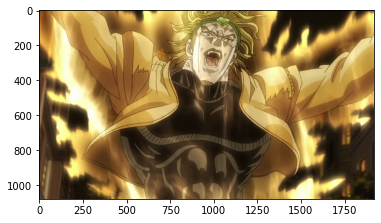

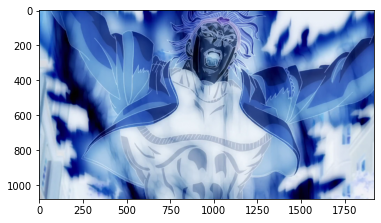

In [3]:
%matplotlib inline
from datetime import datetime
tiempo_total = datetime.now()

import matplotlib.pyplot as plt
import numpy
from PIL import Image 
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0

img_nombre = 'imagen.png'
image = Image.open( img_nombre ) 
  
# summarize some details about the image 
img_alto, img_ancho = image.size 

# Convierto la imagen comprimida en JPEG/PNG a array
img_O_cpu = numpy.asarray(image)
img_R_cpu = numpy.empty_like( img_O_cpu)

tiempo_CPU_img = datetime.now()

# Invertir colores CPU
for y  in range( 0, img_alto ):
  for x in range( 0, img_ancho ):
#    print( x, y, img_pic_cpu[x][y] )
    pixel_R, pixel_G, pixel_B = img_O_cpu[x][y]
    img_R_cpu[x][y] = [ 255 - pixel_R,  255 - pixel_G , 255 - pixel_B]


tiempo_CPU_img = datetime.now() - tiempo_CPU_img


# Muestro los atributos de la imagen y como se ve antes del seudo filtro.
print("Imagen del filtro: " + img_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )  

# Muestro la imagen Original el filtro.
plt.figure()
imgplot=plt.imshow( img_O_cpu )

plt.figure()
imgplot = plt.imshow(img_R_cpu)

tiempo_total = datetime.now() - tiempo_total

print("Tiempo TOTAL: ", tiempo_en_ms( tiempo_total ), "[ms]" )
print( "Tiempo de conversión de imagen por CPU:", tiempo_en_ms( tiempo_CPU_img), "[ms]" )



| Procesador | Imagen dimension | Tiempo Total   | Tiempo Procesador | Hilos   |
|------------|------------------|----------------|-------------------|---------|
| GPU        | 1080 x 1920      | 122.697 (ms)   | 0.379 (ms)        | 16 x 16 |
| CPU        | 1080 x 1920      | 19317.193 (ms) | 19202.606 (ms)    | -       |